# How to simulate

This tutorial helps you to get started with sid by building a simple model. First, it focuses on the core objects which are needed for simulation. Then, the spread of the disease in the artificial population is simulated.

Are we all set? Let's go!

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sid
from sid.config import INDEX_NAMES

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)

## The core objects

This section explains the core objects necessary to run a simulation with sid.


### The `initial_states`

Since sid is an agent-based simulator, it needs information on agents or individuals in the model. This information is captured in the `initial_states`. The `initial_states` are a `pandas.DataFrame` where rows represent individuals and columns are characteristics, for example, age, geographic information, etc..

In this context, a state is a single row in the data frame representing an individual at a certain point in time. The characteristics contain all the information needed for the individual to make decisions such as going to work, demanding a test, or for policies to target the individual.

The following states include information on the age of individuals who fall into different age brackets. The age brackets are necessary for some stochastic processes in the model. For example, the probability of staying asymptomatic after an infection is age-dependent since elderly are more likely to experience strong symptoms.

The states also include very broad geographic information of the individuals which only there to speed up simulation.

We start with 10,000 individuals. Note that all characteristics are converted to categoricals which ensures that values are self-explanatory and save memory.

In [2]:
n_individuals = 10_000
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=n_individuals)
regions = np.random.choice(["North", "East", "South", "West"], size=n_individuals)

initial_states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")
initial_states.head(5)

,age_group,region
0,0-9,North
1,20-29,South
2,70-79,South
3,0-9,West
4,10-19,East


### The `contact_models`

The contact models are key to how contacts between individuals can be modeled with sid. There are two types of contact models, random and recurrent models:

- Recurrent contact models are used when people belong to a certain group and if they meet this group, they meet all participating members. You would use recurrent models to model school classes, households, and colleagues/work groups.

- Random contact models are used when people do not always meet the same predefined groups, but contacts happen more randomly. Usually, people are more likely to meet a person from their own group, but there is also a lower probability of meeting someone from another group. Groups can be formed by combining any number of characteristics. If we would use age groups, we would say contacts are assortative by age. Each person also has a budget for the number of people she can meet. You would use random contact models, for example, to model meetings during freetime activities, infrequent contacts at work, or acquaintances.

In the following, we define a random contact model which lets each individual in the population meet 0-9 other people each day. The contacts are assortative by age and region since we want to make contacts more likely within the same regions and in the same age groups.

In [3]:
def meet_people(states, params, seed):
    np.random.seed(seed)
    contacts = np.random.choice(np.arange(10), size=len(states))
    return pd.Series(contacts, index=states.index)

In [4]:
contact_models = {
    "meet_people": {
        "model": meet_people,
        "assort_by": ["age_group", "region"],
        "is_recurrent": False,
    }
}

Contact models are stored as a dictionary. Our contact model is called ``"meet_people"`` and we define it in another dictionary. The dictionary has the following components.

- ``"model"`` holds the function which maps individual characteristics with parameters to a number of contacts which can be an integer or a float -- internally the number of contacts is rounded over the whole population while preserving the sum of contacts.
- ``"assort_by"`` specifies the variables by which people are more likely to meet each other.
- ``"is_recurrent"`` is an indicator for a whether the models represents recurrent or random contacts.

### The `params`

The parameters are a ``pandas.DataFrame`` and include medical and other relevant information. sid offers a prepared database which can be loaded and easily adjusted. The following code can be used for loading.

In [5]:
params = sid.load_epidemiological_parameters()
params.head(5)

value
category           subcategory        name                     
health_system      icu_limit_relative icu_limit_relative  50.00
cd_infectious_true all                1                    0.39
                                      2                    0.35
                                      3                    0.22
                                      5                    0.04

The index is a three dimensional multi index which allows to organize parameters hierarchically. If lower levels are not necessary, it is common to repeat the previous level.

For our model, we need to specify some additional parameters. First, we add the infection probability for our contact model. If a contact happens between an infectious and a susceptible person, the susceptible person becomes infected according to this probability.

In [6]:
params.loc[("infection_prob", "meet_people", "meet_people"), "value"] = 0.05

Similarly, we specify for each contact model how the strength of the assortative matching.

We assume that 90% of contacts are with people from the same region and 50% with contacts from the same age group. It means that the probability of meeting someone from the same age group and region is 0.45. The rest of the probability mass will be split equally between the remaining groups formed by regions and age groups.

In [7]:
params.loc[("assortative_matching", "meet_people", "age_group"), "value"] = 0.5
params.loc[("assortative_matching", "meet_people", "region"), "value"] = 0.9

We further have to specify parameters governing the immunity level and its waning. For a detailed explaination of these parameters see the tutorial notebook on how to model immunity.

In [8]:
immunity_params = pd.read_csv("immunity_params.csv", index_col=INDEX_NAMES)

params = pd.concat((params, immunity_params))

### The `initial_conditions`

Finally, we need to set the `initial_conditions` which describes the progression of the disease at the start of the simulation like who is infected or already immune, etc.. sid gives you the ability to start the progression of the infectious disease from patient zero. It also offers a simple interface to come up with complex patterns like individuals in all stages of the disease.

For now, we assume that there are 100 infected individuals and 50 with pre-existing immunity.

In [9]:
initial_conditions = {"initial_infections": 100, "initial_immunity": 50}

## The simulation

Now, we are going to simulate this population for 200 periods. For that, we define a duration which is a dictionary with a ``"start"`` and a ``"periods"`` key or a ``"start"`` and ``"end"`` keys.

In [10]:
duration = {"start": "2020-02-27", "periods": 200}

sid differentiates between the setup of the simulation and the actual simulation. That is why we need to build the ``simulation()`` function first. 

In [11]:
simulate = sid.get_simulate_func(
    initial_states=initial_states,
    contact_models=contact_models,
    params=params,
    initial_conditions=initial_conditions,
    duration=duration,
    seed=0,
)

After that, the function to simulate the data only depends on the parameters. Now, let us simulate our model!

In [12]:
result = simulate(params=params)

Start the simulation...
2020-09-13: 100%|██████████| 200/200 [00:23<00:00,  8.40it/s]


The result object is a dictionary with two keys:

- ``"time_series"`` is a ``dask.dataframe`` which holds the data generated by the simulation. Since it is not feasible to hold all the data from the simulation in memory, each day is stored on disk in compressed ``.parquet`` files. ``dask`` provides a convenient interface to load all files and perform calculation on the data. If you want to work with ``pandas.DataFrame``s instead, convert the ``dask.dataframe`` to ``pandas`` with ``time_series.compute()``.

- ``"last_states"`` holds a ``dask.dataframe`` of the lastly simulated states including all data columns which are usually dropped to save memory. The ``last_states`` can be used to resume a simulation.

In [13]:
result.keys()

dict_keys(['time_series', 'last_states'])

Here is a preview for each of the two objects.

In [14]:
result["time_series"].head()

,immunity,date,ever_vaccinated,newly_deceased,knows_infectious,region,new_known_case,is_tested_positive_by_rapid_test,cd_infectious_false,infectious,needs_icu,knows_immune,n_has_infected,virus_strain,newly_vaccinated,newly_infected,age_group,dead,ever_infected,symptomatic
0,0.0000,2020-08-29,False,False,False,North,False,False,-10185,False,False,False,0,NaN,False,False,0-9,False,False,False
1,0.0000,2020-08-29,False,False,False,South,False,False,-10185,False,False,False,0,NaN,False,False,20-29,False,False,False
2,0.9757,2020-08-29,False,False,False,South,False,False,-144,False,False,False,0,base_strain,False,False,70-79,False,True,False
3,0.0000,2020-08-29,False,False,False,West,False,False,-10185,False,False,False,0,NaN,False,False,0-9,False,False,False
4,0.9758,2020-08-29,False,False,False,East,False,False,-139,False,False,False,3,base_strain,False,False,10-19,False,True,False


In [15]:
result["last_states"].head()

,age_group,region,ever_infected,infectious,symptomatic,needs_icu,dead,pending_test,received_test_result,knows_immune,...,cd_knows_infectious_false_draws,cd_needs_icu_false_draws,cd_needs_icu_true_draws,cd_received_test_result_true_draws,cd_symptoms_false_draws,cd_symptoms_true_draws,group_codes_meet_people,date,period,n_contacts_meet_people
0,0-9,North,False,False,False,False,False,False,False,False,...,-1,-1,-1,2,27,-1,1,2020-09-13,621,5
1,20-29,South,False,False,False,False,False,False,False,False,...,-1,45,-1,4,18,-1,10,2020-09-13,621,3
2,70-79,South,True,False,False,False,False,False,False,False,...,-1,15,-1,2,18,1,30,2020-09-13,621,1
3,0-9,West,False,False,False,False,False,False,False,False,...,-1,25,-1,1,27,-1,3,2020-09-13,621,0
4,10-19,East,True,False,False,False,False,False,False,False,...,-1,-1,-1,1,27,-1,4,2020-09-13,621,6


Let us take a look at various statistics of the sample.

In [16]:
df = result["time_series"].compute()

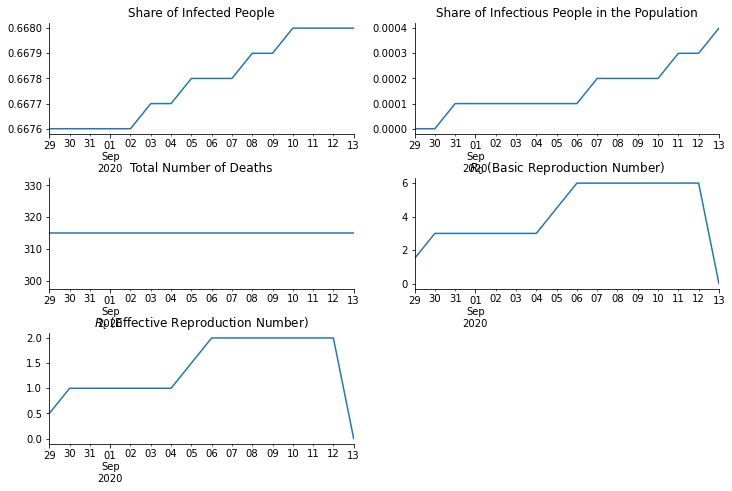

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

df.resample("D", on="date")["ever_infected"].mean().plot(ax=axs[0])
df.resample("D", on="date")["infectious"].mean().plot(ax=axs[1])
df.resample("D", on="date")["dead"].sum().plot(ax=axs[2])

r_zero = sid.statistics.calculate_r_zero(df, window_length=7)
r_zero.plot(ax=axs[3])

r_effective = sid.statistics.calculate_r_effective(df, window_length=7)
r_effective.plot(ax=axs[4])

for ax in axs:
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_0$ (Basic Reproduction Number)")
axs[4].set_title("$R_t$ (Effective Reproduction Number)")

axs[5].set_visible(False)

plt.show()